In [1]:
import networkx as nx
import scipy.io
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
mat = scipy.io.loadmat('traffic_dataset.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'tra_X_tr', 'tra_X_te', 'tra_Y_tr', 'tra_Y_te', 'tra_adj_mat'])

<h3>Graph Structure</h3>

<h4> Nodes </h4>

represents a location with a sensor

Node features:
   Traffic Voume 10  
   week day 7
   hour of day 24
   road direction 4
   Number of lanes
   Name of road
   


<h4> Edges </h4>

represent traffic connectivity between locations/sensors

Since there are no edge features, I'll parametrize edge_weights between sensors in the model
   
 



In [3]:
def sm_to_array(sm):
    return sparse.csr_matrix(sm).toarray()


def convert_to_npm(mat_dict):    
    npm = []

    for i in range(mat_dict.shape[1]):
        sm = mat_dict[:,i][0]
        npm.append(sm_to_array(sm))

    return(np.array(npm))
    

In [4]:
X_train = convert_to_npm(mat['tra_X_tr'])
X_test = convert_to_npm(mat['tra_X_te'])
y_train = mat['tra_Y_tr']
y_test = mat['tra_Y_te']
adj_mat = mat['tra_adj_mat']

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(adj_mat.shape)

(1261, 36, 48)
(840, 36, 48)
(36, 1261)
(36, 840)
(36, 36)


In [6]:
adj_mat

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Next I'll check to see if there are any features that are zeros for all sensors in all the rows

In [7]:
len(X_train)

1261

In [8]:
X_train[0].shape

(36, 48)

In [9]:
null_count = np.zeros(48)

for time in X_train:
    for f in range(48):
        if sum(time[:,f]) == 0:
            null_count[f] += 1

In [10]:
null_count

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,  973.,  973.,  973., 1056., 1069., 1205., 1205., 1205.,
       1208., 1209., 1209., 1209., 1209., 1209., 1209., 1209., 1209.,
       1209., 1209., 1209., 1209., 1209., 1209., 1209., 1209., 1209.,
       1209., 1209., 1209.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.])

In [11]:
null_count = np.zeros(48)

for time in X_test:
    for f in range(48):
        if sum(time[:,f]) == 0:
            null_count[f] += 1

null_count

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 648.,
       657., 744., 663., 648., 808., 808., 808., 805., 804., 804., 804.,
       804., 804., 804., 804., 804., 805., 805., 804., 804., 804., 804.,
       804., 804., 804., 805., 808., 808.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.])

looks like none of the features are null

In [12]:
adj_mat

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
G = nx.Graph()

G.add_nodes_from(range(36))

for i in range(len(adj_mat)):
    for j in range(i+1,len(adj_mat)):
        if adj_mat[i][j] == 1:
            G.add_edge(i,j)
            G.add_edge(j,i)

In [14]:
degree_feature_tr = np.zeros((1261,36))
degree_feature_te = np.zeros((840,36))
for i in range(36):
    degree = G.degree[i]
    degree_feature_tr[:,i] = np.repeat(degree,1261)
    degree_feature_te[:,i] = np.repeat(degree,840)

X_train = np.concatenate((X_train,degree_feature_tr.reshape((1261,36,1))),axis=2)
X_test = np.concatenate((X_test,degree_feature_te.reshape((840,36,1))),axis=2)

In [15]:
X_train.shape

(1261, 36, 49)

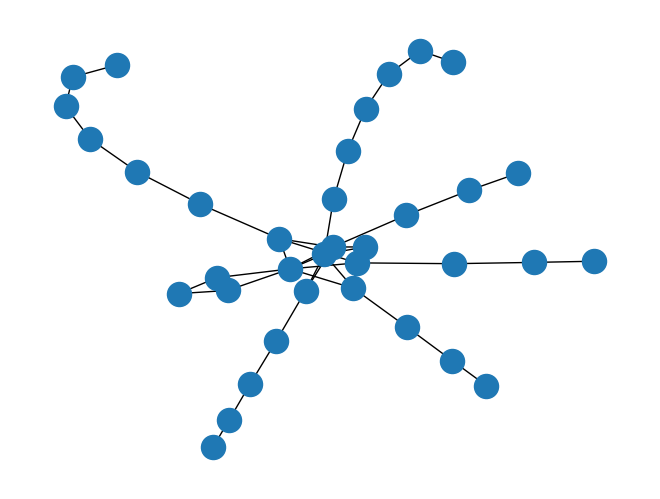

In [16]:
nx.draw(G)

Setting up testing and training iterators below

In [17]:
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

train_iter = StaticGraphTemporalSignal(
    edge_index= np.array(list(G.edges())).transpose(),
    edge_weight=np.ones(len(G.edges)),
    features = X_train,
    targets = y_train.T#[4,:].reshape((1261,1))
)

test_iter = StaticGraphTemporalSignal(
    edge_index= np.array(list(G.edges())).transpose(),
    edge_weight=np.ones(len(G.edges)),
    features = X_test,
    targets = y_test.T#[4,:].reshape((840,1))
)

In [18]:
for time, snapshot in enumerate(train_iter):
    print(snapshot.x.shape)
    print(snapshot.edge_index.shape)
    print(snapshot.edge_attr.shape)
    print(snapshot.num_nodes)
    print(snapshot.num_edge_features)
    print(snapshot.y.shape)
    break

torch.Size([36, 49])
torch.Size([2, 43])
torch.Size([43])
36
1
torch.Size([36])


In [19]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric_temporal.nn.recurrent import GConvLSTM
from torch_geometric.nn.conv import SAGEConv,GraphConv
from torch_geometric.nn import GraphSAGE    
from torch_geometric.nn.norm import GraphNorm

class GLSTM(torch.nn.Module):
    def __init__(self, node_features, filters,num_edges):
        super(GLSTM, self).__init__()
        self.recurrent = GConvLSTM(node_features, filters, 3)
        self.sage = SAGEConv(filters,1,project=True)                           
        self.edge_weight = nn.Parameter(torch.ones(num_edges,dtype=torch.float)) #parametrizing edge weight since there aren't any edge features
        
    def forward(self, x, edge_index, hidden_state, cell_state):
        
        h,c = self.recurrent(x, edge_index, self.edge_weight,H=hidden_state,C=cell_state)
        
        y = F.relu(h)
        y = self.sage(y,edge_index)

        return y,h,c

In [20]:
from tqdm import tqdm
          

batch_size = 4
model = GLSTM(node_features=49,filters=32,num_edges=86)
loss = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)   #Using Adam 

tr_preds = []
tr_y = []

train_loss = []
test_loss = []

vmse = torch.vmap(loss) #calculate mse per sensor

In [27]:
from torch_geometric.transforms import ToUndirected 
t = tqdm(range(200),leave=True)
undirect = ToUndirected()
for epoch in t:
    model.train()
    
    H = None
    C = None
    
    mean_mse_tr = torch.zeros(1)
    cost = torch.zeros(1)
    for time, snapshot in enumerate(train_iter):
        snapshot = undirect(snapshot)
       
        y_hat,H,C = model(snapshot.x, snapshot.edge_index, H, C)
        
        cost = cost + torch.amax(vmse(y_hat,snapshot.y))   #optimizing for worst performing sensor
        mean_mse_tr = mean_mse_tr + torch.mean(vmse(y_hat,snapshot.y))
            
        if time % batch_size == 0 or time == 1260:
            cost.backward()
            optimizer.step()
            
            optimizer.zero_grad()
            cost = 0
            H = None
            C = C.detach()
        
    with torch.no_grad():
        H_t = None
        C_t = None
        model.eval()
        mean_mse_te = 0
        for ttime, tsnapshot in enumerate(test_iter):
            tsnapshot = undirect(tsnapshot)                                      
            pred,H_t,C_t = model(tsnapshot.x, tsnapshot.edge_index, H_t,C_t)
            mean_mse_te = mean_mse_te + torch.mean(vmse(pred,tsnapshot.y))
            
            if ttime % batch_size == 0:
                H_t = None
            
        mean_mse_te = mean_mse_te.item() / (ttime+1)
        test_loss.append(mean_mse_te)

    train_loss.append(mean_mse_tr/(time+1))
        
    
    if epoch % 5 == 0:
        torch.save(model.state_dict(),f'models/modelat{len(test_loss)}.pth')
    t.set_description(f'train MSE:{train_loss[-1].item():3f}, test MSE:{test_loss[-1]:3f}')
    

train MSE:0.001298, test MSE:0.002130:  31%|███       | 62/200 [09:01<20:05,  8.73s/it]


KeyboardInterrupt: 

In [38]:
model.state_dict()['edge_weight']

tensor([0.7972, 0.9532, 0.7926, 1.0434, 1.0381, 0.8952, 0.9168, 0.9129, 0.9866,
        0.9758, 0.9086, 0.9078, 0.9526, 0.9343, 0.8911, 0.9156, 0.8824, 1.0408,
        0.7999, 1.0109, 0.8764, 0.8524, 0.9235, 0.9727, 1.1004, 0.8487, 0.9521,
        0.9087, 0.8645, 0.8471, 0.9632, 0.9278, 0.8406, 0.7878, 0.8132, 0.7734,
        0.9563, 0.9750, 0.8087, 1.0050, 0.8373, 1.0537, 0.8031, 1.0200, 0.9114,
        0.9071, 0.8891, 0.9509, 0.9048, 1.0104, 0.8608, 0.9501, 0.9696, 0.8093,
        0.9730, 1.0158, 0.9350, 0.8701, 1.0090, 0.7700, 1.0427, 0.7951, 1.1303,
        0.8978, 1.0489, 1.0128, 1.0233, 0.8318, 0.9388, 0.8546, 0.6795, 0.7210,
        0.6861, 1.1457, 0.9411, 0.9157, 0.8915, 0.9194, 0.9520, 0.8601, 0.9046,
        1.0188, 0.8822, 0.8560, 0.9621, 0.7997])

In [26]:
len(train_loss)

200

In [39]:
train_loss[261]

tensor([0.0013])

In [33]:
test_loss[201]

0.002156978419848851

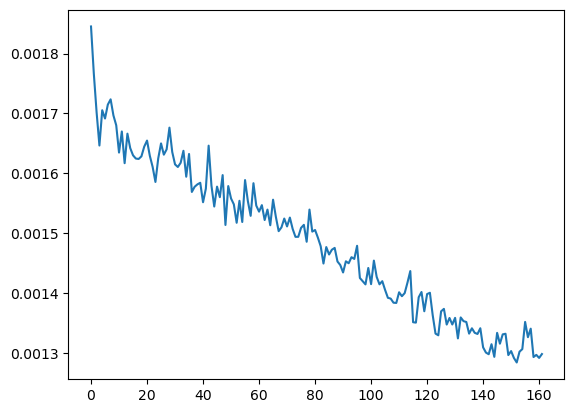

In [32]:
plt.plot(train_loss[100:])
#plt.plot(test_loss[100:])

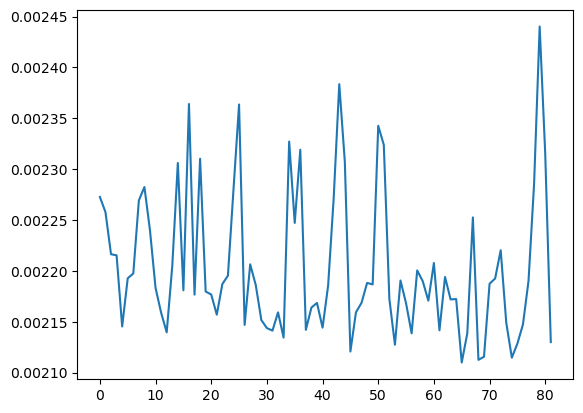

In [37]:
plt.plot(test_loss[180:])

In [ ]:
len(test_loss)

In [ ]:
len(train_loss)

In [41]:
H_t = None
C_t = None
preds = []
true = []
model.eval()
mean_mse_te = 0
for ttime, tsnapshot in enumerate(test_iter):
    tsnapshot = undirect(tsnapshot)
    pred,H_t,C_t = model(tsnapshot.x, tsnapshot.edge_index, H_t,C_t)
    mean_mse_te = mean_mse_te + torch.mean(vmse(pred,tsnapshot.y))
    preds.append(pred.detach().numpy())
    true.append(tsnapshot.y.detach().numpy())
    if ttime%batch_size == 0:
        H_t = None

mean_mse_te = mean_mse_te/(ttime+1)

/Users/asadsabir/anaconda3/envs/traffic/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [42]:
mean_mse_te

tensor(0.0023, grad_fn=<DivBackward0>)

In [45]:
test_loss[-2]

0.002314949603307815

In [ ]:
preds = np.array(preds).reshape((840,36))
true = np.array(true)

In [ ]:
for s in range(36):
    plt.plot(true[:,s])
    plt.plot(preds[:,s])
    plt.show()
    

In [ ]:
H_t = None
C_t = None
model.eval()
mean_mse_te = 0
for ttime, tsnapshot in enumerate(test_iter):                                      
    pred,H_t,C_t = model(tsnapshot.x, tsnapshot.edge_index, H_t,C_t)
    mean_mse_te = mean_mse_te + torch.mean(vmse(pred,tsnapshot.y))
    
    if time % batch_size == 0:
        H_t = None
    
mean_mse_te = mean_mse_te.item() / (ttime+1)

In [49]:
train_loss[244]

tensor([0.0013])

In [46]:
bi = 6
v = 1
for i,b in enumerate(test_loss):
    if i % 5 == 0 and b < v:
        v = b
        bi = i

print(bi+1,v)

246 0.002109978028706142


In [ ]:
torch.save(model.state_dict(),'modelat165.pth')

In [ ]:
def objective(config):

    class GLSTM(torch.nn.Module):
        def __init__(self, node_features, filters,num_edges):
            super(GLSTM, self).__init__()
            self.recurrentin = GConvLSTM(node_features, filters, config['K'])
            self.recurrent = nn.ModuleList([GConvLSTM(filters, filters, config['K']) for _ in range(config['GNN_cells']-1)])
                                       
            
            self.edge_weight = nn.Parameter(torch.ones(num_edges,dtype=torch.float))
            self.Lw = nn.Parameter(torch.ones((36,filters),dtype=torch.float))
            self.Lb = nn.Parameter(torch.zeros(36,dtype=torch.float))
            
        def forward(self, x, edge_index, hidden_state, cell_state):
            hs = []
            cs = []
            
            h,c = self.recurrentin(x, edge_index, self.edge_weight,H=hidden_state[0],C=cell_state[0])
            hs.append(h)
            cs.append(c)

            for i,cell in enumerate(self.recurrent):
                h_n,c_n = cell(hs[-1], edge_index, self.edge_weight,H=hidden_state[i+1],C=cell_state[i+1])
                hs.append(h_n)
                cs.append(c_n)

            y = F.relu(hs[-1])

            y = torch.tensordot(self.Lw,y,dims=2)
            y = torch.add(y,self.Lb)

            return y,hs,cs
        
    
    model = GLSTM(node_features=48,filters=config['filters'],num_edges=43)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    batch_size = config['batch_size']
    test_loss = []
    

    for epoch in range(200):
        model.train()
        
        H = [None for _ in range(config['GNN_cells'])]
        C = [None for _ in range(config['GNN_cells'])]
        cost = torch.zeros(1)
        for time, snapshot in enumerate(train_iter):
            y_hat,H,C = model(snapshot.x, snapshot.edge_index, H, C)
            cost = cost + torch.mean((y_hat-snapshot.y)**2)
            
            if time%batch_size == 0 or time == 1260:
                cost.backward()
                optimizer.step()
                optimizer.zero_grad()
                cost = 0
                H = [None for _ in range(config['GNN_cells'])]
                C = [None for _ in range(config['GNN_cells'])]
        with torch.no_grad():
            H_t = [None for _ in range(config['GNN_cells'])]
            C_t = [None for _ in range(config['GNN_cells'])]
            model.eval()
            test_cost = 0
            for ttime, tsnapshot in enumerate(test_iter):
                pred,H_t,C_t = model(tsnapshot.x, tsnapshot.edge_index, H_t,C_t)
                test_cost = test_cost + torch.mean((pred-tsnapshot.y)**2)

            test_cost = test_cost / (ttime+1)
            test_cost = test_cost.item()
            test_loss.append(test_cost)
    
    return np.min(test_loss)
    

In [ ]:
from ray import train, tune

search_space = {
    'batch_size':tune.grid_search([3,4,5,6,7]),
    'GNN_cells':tune.grid_search([1,2,3]),
    'K':tune.choice([2,3,4,5]), 
    'filters':tune.choice(range(10,36))
}
tuner = tune.Tuner(objective, param_space=search_space)  # ③

results = tuner.fit()
print(results.get_best_result(metric="score", mode="min").config)

In [ ]:
print(results.get_best_result(metric="_metric", mode="min").config)